In [1]:
#Implementation of Harris Corner Detector

#Import Libraries
import skimage
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import imageio
import scipy
from scipy import ndimage
import random
from sklearn.cluster import DBSCAN

In [2]:
def gaus_der_blur(Img, sigma):
    m_size= np.ceil(3*sigma)*2+1 
    m_size= m_size.astype(int)
    val=np.linspace(-np.ceil(3*sigma),np.ceil(3*sigma),m_size)
    g=(val/(np.sqrt(2*np.pi)*sigma**3))*np.exp(-val**2/(2*sigma**2))
    g_nor=g/sum(abs(g))
    check=sum(abs(g_nor))

    I_X=scipy.ndimage.convolve(Img, np.expand_dims(g_nor, axis=0), mode='nearest')
    I_Y=scipy.ndimage.convolve(Img, np.vstack(g_nor), mode='nearest')
    return I_X, I_Y

In [3]:
def gaus_blur(img, sigma):
    m_size= np.ceil(3*sigma)*2+1 
    m_size= m_size.astype(int)
    val=np.linspace(-np.ceil(3*sigma),np.ceil(3*sigma),m_size)
    g=1/(np.sqrt(2*np.pi)*sigma)*np.exp(-val**2/(2*sigma**2))
    g_nor=g/sum(g)

    con_x=scipy.ndimage.convolve(img, np.expand_dims(g_nor, axis=0), mode='nearest')
    Smoothed_Im=scipy.ndimage.convolve(con_x, np.vstack(g_nor), mode='nearest')
    return Smoothed_Im

6.0

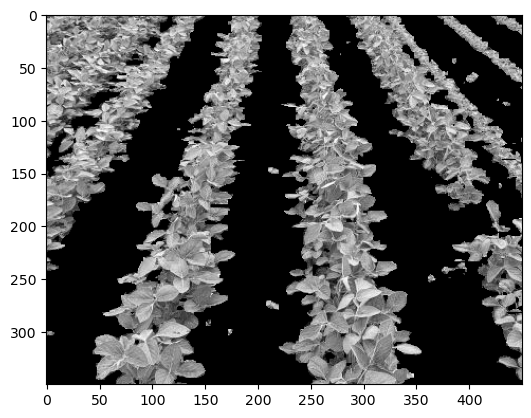

In [4]:
img= io.imread('MSU.jpg')
img_g=img[:, :, 1]
img_r=img[:,:,0]
img_new=img_r*0
r,c=img_r.shape
for i in range(r):
    for j in range(c):
        if img_g[i,j]>img_r[i,j]:
            img_new[i,j]=img_g[i,j]
           
        else:
            img_new[i,j]=0
plt.imshow(img_new,cmap='grey')  
filt_img=img_new[150:500,100:550]
plt.imshow(filt_img,cmap='grey') 



# getting the number of clusters for k mens clustering
r2,c2=filt_img.shape
row=random.sample(range(r2), 25)
subt=[0]*(c2-1)
prek=[0]*25
k=[0]*25
#for it in range(3):
for v in range (25): 
    est=0
    for o in range (c2-7):
        subt=abs(int(filt_img[row[v], o])-int(filt_img[row[v], o+1]))>100
        est=est+subt
    k[v]=est

k=np.median(k)
display(k)

In [8]:
print(np.min(filt_img))

0


In [18]:

alpha=0.05

I_x,I_y=gaus_der_blur(filt_img, sigma=0.7)


I_x_2=I_x*I_x
I_y_2=I_y*I_y
I_xy=I_x*I_y

I_x_2b=gaus_blur(I_x_2, sigma=1)
I_y_2b=gaus_blur(I_y_2, sigma=1)
I_xy_b=gaus_blur(I_xy, sigma=1)
R=I_x_2b*I_y_2b-I_xy_b*I_xy_b-alpha*((I_x_2b+I_y_2b)**2)


Text(0.5, 1.0, 'Non maximum Suppression R')

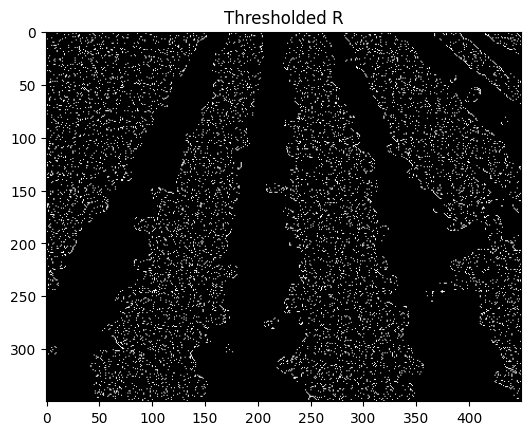

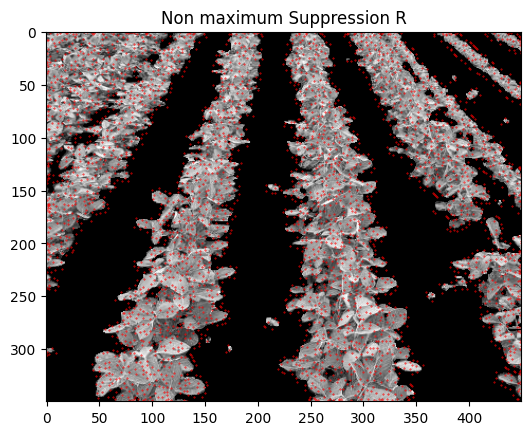

In [19]:
#setting threshold
T=230
tIm = R > T
R_new=tIm*R
plt.figure()
plt.imshow(R_new,cmap='grey')
plt.title('Thresholded R')

r,c=R.shape
for p in range(3,(r-3)):
    for o in range(3,(c-3)):
        if R_new[p,o]!=np.max(R_new[(p-3):(p+3),(o-3):(o+3)]):
            R_new[p,o]=0
xlow,ylow=np.nonzero(R_new)            
plt.figure()        
plt.scatter(ylow,xlow, s=0.15,color='red')
plt.imshow(filt_img,cmap='grey')
plt.title('Non maximum Suppression R')


In [20]:
#kmeans
k=int(k)
c=[0]*k
dist=[0]*k
closestcluster=[0]*xlow
new_centers=c
num_occ=[0]*k
#randomly assigning cluster centers
centers=random.sample(range(len(xlow)), k)

for i in range(k):
    c[i]=[xlow[centers[i]],ylow[centers[i]]] 
c=np.asmatrix(c)
for v in range(1000):
    for g in xlow:
        for h in range(k):
            dist[h]=(((xlow[g]-c[h,0])**2)+((ylow[g]-c[h,1])**2))**0.5
        closestcluster[g]=dist.index(min(dist))
    #checking that each cluster has at leat 1 point
    for u in range(k):
        num_occ[u]=sum(closestcluster==u)
        
    sumx=[0]*k
    sumy=[0]*k
    for u in xlow:
        for p in range(k):
            if closestcluster[u]==p:
                sumx[p]= xlow[u]+sumx[p]
                sumy[p]= ylow[u]+sumy[p]
            
# if there is a match move the center move the center of cluster, if not assign it to a diffent random point
    for q in range(k):
        if num_occ[q]==0:
            reassign=random.randint(0,len(xlow)-1)
            new_centers[q]=[xlow[reassign],ylow[reassign]] 
        else:
            new_centers[q]=[sumx[q]/num_occ[q], sumy[q]/num_occ[q]]
    c=np.asmatrix(new_centers)


[13534, 0, 2560, 0, 11441, 4555, 0]

matrix([[  8.27261614, 160.15709046],
        [105.        , 271.        ],
        [  9.48148148, 436.32222222],
        [ 88.        , 375.        ],
        [ 12.35529158, 340.91576674],
        [ 10.69248826,  20.33568075],
        [177.        , 143.        ]])

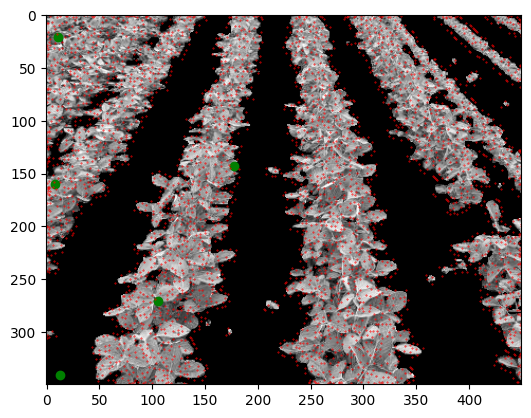

In [21]:
sumx=[0]*k
sumy=[0]*k
num_occ=[0]*k
new_centers=[0]*k
for u in xlow:
    for p in range(k):
        if closestcluster[u]==p:
            sumx[p]= xlow[u]+sumx[p]
            sumy[p]= ylow[u]+sumy[p]
            num_occ[p]=num_occ[p]+1
# if there is a match move the center of cluster, if not reassign cluster
for q in range(k):
    if num_occ[q]==0:
        reassign=random.randint(0,len(xlow)-1)
        new_centers[q]=[float(c[q,0]),float(c[q,1])]
    else:
        new_centers[q]=[sumx[q]/num_occ[q], sumy[q]/num_occ[q]]
new_centers=np.asmatrix(new_centers)
display(sumx)

display(new_centers)
plt.figure()
plt.scatter(np.array(new_centers[:,0]),np.array(new_centers[:,1]),color='green')
plt.scatter(ylow,xlow, s=0.15,color='red')
plt.imshow(filt_img,cmap='grey')

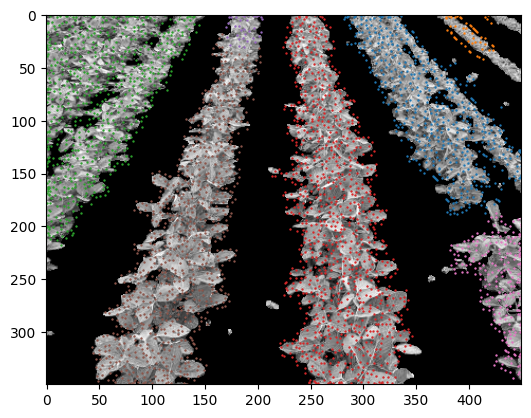

In [22]:

db = DBSCAN(eps=20.125, min_samples=35).fit(np.c_[ylow,xlow])
label = db.labels_

clustery=[0]*7
clusterx=[0]*7
for u in range(7):
    clustery[u] = ylow[label == u]
    clusterx[u] = xlow[label == u] 
#plotting the results
plt.scatter(clustery[0] , clusterx[0], s=0.5)
plt.scatter(clustery[1] , clusterx[1], s=0.5)
plt.scatter(clustery[2] , clusterx[2], s=0.5)
plt.scatter(clustery[3] , clusterx[3], s=0.5)
plt.scatter(clustery[4] , clusterx[4], s=0.5)
plt.scatter(clustery[5] , clusterx[5], s=0.5)
plt.scatter(clustery[6] , clusterx[6], s=0.5)
plt.imshow(filt_img,cmap='grey')



C:\Users\Bobby\AppData\Local\Temp\ipykernel_8852\1595448402.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  m=(ylow[p2]-ylow[p1])/(xlow[p2]-xlow[p1])
C:\Users\Bobby\AppData\Local\Temp\ipykernel_8852\1595448402.py:10: RuntimeWarning: invalid value encountered in scalar divide
  m=(ylow[p2]-ylow[p1])/(xlow[p2]-xlow[p1])
C:\Users\Bobby\AppData\Local\Temp\ipykernel_8852\1595448402.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  if ylow[j]-m*xlow[j]>bL and ylow[j]-m*xlow[j]<bR:


Text(0.5, 1.0, 'RANSAC Best Points')

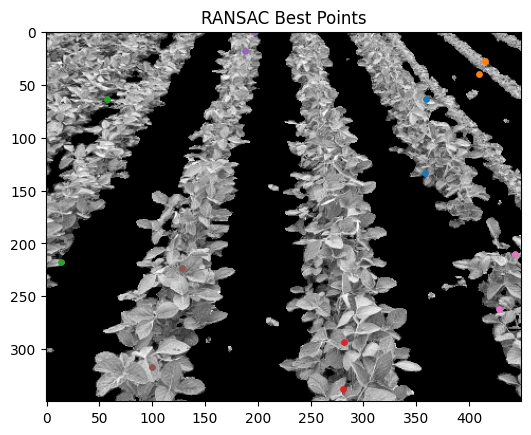

In [23]:
#Simple RANSAC
def RANSAC(Thresh,iter,xlow,ylow):
    best_metrics=[0,0,0]
    for k in range (iter):
        matches=0
        #selecting two random points
        p1=random.randint(0,len(xlow)-1)
        p2=random.randint(0,len(xlow)-1)
        #getting general form of a line
        m=(ylow[p2]-ylow[p1])/(xlow[p2]-xlow[p1])
        #create parallel line Threshold away
        bL=ylow[p2]-m*(xlow[p2]-Thresh)
        bR=ylow[p2]-m*(xlow[p2]+Thresh)
        for j in range(len(xlow)):
            if ylow[j]-m*xlow[j]>bL and ylow[j]-m*xlow[j]<bR:
                matches=matches+1
        cur_metrics=[p1,p2,matches]
        if cur_metrics[-1]>best_metrics[-1]:
            best_metrics=cur_metrics
            
    return best_metrics        
    
points_zero=RANSAC(60, 1000, clustery[0], clusterx[0])
points_one=RANSAC(60, 1000, clustery[1], clusterx[1]) 
points_two=RANSAC(60, 1000, clustery[2], clusterx[2]) 
points_three=RANSAC(60, 1000, clustery[3], clusterx[3]) 
points_four=RANSAC(60, 1000, clustery[4], clusterx[4]) 
points_five=RANSAC(60, 1000, clustery[5], clusterx[5]) 
points_six=RANSAC(60, 1000, clustery[6], clusterx[6]) 
 
plt.figure()        
plt.scatter([clustery[0][points_zero[0]], clustery[0][points_zero[1]]],[clusterx[0][points_zero[0]], clusterx[0][points_zero[1]]], s=15)
plt.scatter([clustery[1][points_one[0]], clustery[1][points_one[1]]],[clusterx[1][points_one[0]], clusterx[1][points_one[1]]], s=15)
plt.scatter([clustery[2][points_two[0]], clustery[2][points_two[1]]],[clusterx[2][points_two[0]], clusterx[2][points_two[1]]], s=15)
plt.scatter([clustery[3][points_three[0]], clustery[3][points_three[1]]],[clusterx[3][points_three[0]], clusterx[3][points_three[1]]], s=15)
plt.scatter([clustery[4][points_four[0]], clustery[4][points_four[1]]],[clusterx[4][points_four[0]], clusterx[4][points_four[1]]], s=15)
plt.scatter([clustery[5][points_five[0]], clustery[5][points_five[1]]],[clusterx[5][points_five[0]], clusterx[5][points_five[1]]], s=15)
plt.scatter([clustery[6][points_six[0]], clustery[6][points_six[1]]],[clusterx[6][points_six[0]], clusterx[6][points_six[1]]], s=15)
plt.imshow(filt_img,cmap='grey')
plt.title('RANSAC Best Points')

